<a href="https://colab.research.google.com/github/ArosevMaxim/BDP_SOL/blob/main/%D0%9F%D0%A0_5_%D0%90%D1%80%D0%BE%D1%81%D0%B5%D0%B2_%D0%9C%D0%B0%D0%BA%D1%81%D0%B8%D0%BC_%D0%93%D0%B5%D0%BE%D1%80%D0%B3%D0%B8%D0%B5%D0%B2%D0%B8%D1%87.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Аросев Максим Георгиевич, БД231

Данные: Financial Fraud Detection Dataset, https://www.kaggle.com/datasets/sriharshaeedala/financial-fraud-detection-dataset

# **1. Инициализация платформы Spark и загрузка данных в фрейм данных Spark** <a class="anchor" id="1"></a>

In [1]:
# Импорт модулей, не связанныех с PySpark.
import os
import sys
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import math
from IPython.core.interactiveshell import InteractiveShell
from datetime import *
import statistics as stats
# Это помогает автоматически распечатывать элементы без явного использования «печати».
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=2e368a7292efdc1e4b0c3dada5aaa943e77b1f378ceac42094d5028d1d1d6153
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [9]:
# Импорт модулей, связанных с PySpark.
import pyspark
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions
from pyspark.sql.functions import lit, desc, col, size, array_contains\
, isnan, udf, hour, array_min, array_max, countDistinct, count, sum, min, max
from pyspark.sql.types import *

MAX_MEMORY = '15G'
# Инициализировать сеанс Spark.
conf = pyspark.SparkConf().setMaster("local[*]") \
        .set('spark.executor.heartbeatInterval', 10000) \
        .set('spark.network.timeout', 10000) \
        .set("spark.core.connection.ack.wait.timeout", "3600") \
        .set("spark.executor.memory", MAX_MEMORY) \
        .set("spark.driver.memory", MAX_MEMORY)
def init_spark():
    spark = SparkSession \
        .builder \
        .appName("Pyspark guide") \
        .config(conf=conf) \
        .getOrCreate()
    return spark

spark = init_spark()
filename_data = '/content/drive/MyDrive/data/Bosenko/Synthetic_Financial_datasets_log.csv' # Загрузите данные в текущий каталог Colab.

df = spark.read.option("header", True).csv(filename_data)
print('Data frame type: ' + str(type(df)))

Data frame type: <class 'pyspark.sql.dataframe.DataFrame'>


# **2. Обзор набора данных** <a class="anchor" id="2"></a>


In [10]:
print('Обзор данных')
df.printSchema()
print('Обзор столбцов')
pd.DataFrame(df.dtypes, columns = ['Column Name','Data type'])

Обзор данных
root
 |-- step: string (nullable = true)
 |-- type: string (nullable = true)
 |-- amount: string (nullable = true)
 |-- nameOrig: string (nullable = true)
 |-- oldbalanceOrg: string (nullable = true)
 |-- newbalanceOrig: string (nullable = true)
 |-- nameDest: string (nullable = true)
 |-- oldbalanceDest: string (nullable = true)
 |-- newbalanceDest: string (nullable = true)
 |-- isFraud: string (nullable = true)
 |-- isFlaggedFraud: string (nullable = true)

Обзор столбцов


,Column Name,Data type
0,step,string
1,type,string
2,amount,string
3,nameOrig,string
4,oldbalanceOrg,string
5,newbalanceOrig,string
6,nameDest,string
7,oldbalanceDest,string
8,newbalanceDest,string
9,isFraud,string


In [11]:
print('Описание фрейма данных (только строковые и числовые столбцы):')
df.describe().toPandas()

Описание фрейма данных (только строковые и числовые столбцы):


,summary,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,count,6362620,6362620,6362620,6362620,6362620,6362620,6362620,6362620,6362620,6362620,6362620
1,mean,243.39724563151657,None,179861.9035491287,None,833883.1040744764,855113.6685785812,None,1100701.6665196533,1224996.3982019224,0.001290820448180152,2.51468734577894E-6
2,stddev,142.33197104913066,None,603858.2314629209,None,2888242.673037527,2924048.5029542595,None,3399180.1129944525,3674128.9421196915,0.035904796801604424,0.0015857747057365457
3,min,1,CASH_IN,0.0,C1000000639,0.0,0.0,C1000004082,0.0,0.0,0,0
4,max,99,TRANSFER,99999.81,C999999784,9999991.25,9999991.25,M999999784,999999.69,999999.69,1,1


In [12]:
print(f'Общее количество {df.count()} строк, печатаем несколько первых строк:')
df.limit(2).toPandas()

Общее количество 6362620 строк, печатаем несколько первых строк:


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0


# 3. Обнаружение пропущенных значений и аномальных нулей.

После предварительного просмотра столбцов первое, что должны проверить, — это наличие в наборе данных какого-либо пропущенного значения.
– Для строковых столбцов  проверяем наличие `None` и `null`.
- Для числовых столбцов проверяем наличие нулей и `NaN`.
- Для столбцов типа массив проверяем, содержит ли массив нули или `NaN`.

In [13]:
print('Обзор столбцов')
pd.DataFrame(df.dtypes, columns = ['Column Name','Data type'])

Обзор столбцов


,Column Name,Data type
0,step,string
1,type,string
2,amount,string
3,nameOrig,string
4,oldbalanceOrg,string
5,newbalanceOrig,string
6,nameDest,string
7,oldbalanceDest,string
8,newbalanceDest,string
9,isFraud,string


In [14]:
string_columns = ['type', 'nameOrig', 'nameDest']
numeric_columns = ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest	', 'newbalanceDest', 'isFraud', 'isFlaggedFraud']
array_columns = []
missing_values = {}
for index, column in enumerate(df.columns):
    if column in string_columns:    # проверить столбцы строк со значениями None и Null
#         missing_count = df.filter(col(column).eqNullSafe(None) | col(column).isNull()).count()
#         missing_values.update({column: missing_count})
        missing_count = df.filter(col(column).eqNullSafe(None) | col(column).isNull()).count()
        missing_values.update({column:missing_count})
    if column in numeric_columns:  # check zeroes, None, NaN
        missing_count = df.where(col(column).isin([None,np.nan])).count()
        missing_values.update({column:missing_count})
    if column in array_columns:  # check zeros and NaN
        missing_count = df.filter(array_contains(df[column], 0) | array_contains(df[column], np.nan)).count()
        missing_values.update({column:missing_count})
missing_df = pd.DataFrame.from_dict([missing_values])
missing_df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,newbalanceDest,isFraud,isFlaggedFraud
0,0,0,0,0,0,0,0,0,0,0


In [15]:
df.limit(10).toPandas()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.0,C1305486145,181.0,0.0,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.0,C840083671,181.0,0.0,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0
5,1,PAYMENT,7817.71,C90045638,53860.0,46042.29,M573487274,0.0,0.0,0,0
6,1,PAYMENT,7107.77,C154988899,183195.0,176087.23,M408069119,0.0,0.0,0,0
7,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.0,0,0
8,1,PAYMENT,4024.36,C1265012928,2671.0,0.0,M1176932104,0.0,0.0,0,0
9,1,DEBIT,5337.77,C712410124,41720.0,36382.23,C195600860,41898.0,40348.79,0,0


Проанализируем количество мошеннических операций `Is Laundering` = 1 в разрезе по дням

In [24]:
FRAUD_DF = df \
    .select(df.type, df.amount) \
    .filter(df['IsFraud'] == 0) \
    .distinct() \
    .groupBy(df.type) \
    .agg(count('amount').alias('cnt')).toPandas()


In [25]:
FRAUD_DF = FRAUD_DF.set_index('type').sort_index()
FRAUD_DF

,cnt
type,
CASH_IN,1373068
CASH_OUT,2169867
DEBIT,40448
PAYMENT,1515212
TRANSFER,524929


[Text(0.5, 1.0, 'Количество не мошеннеческих операций'),
 Text(0.5, 0, 'Тип операции'),
 Text(0, 0.5, 'Количество операций')]

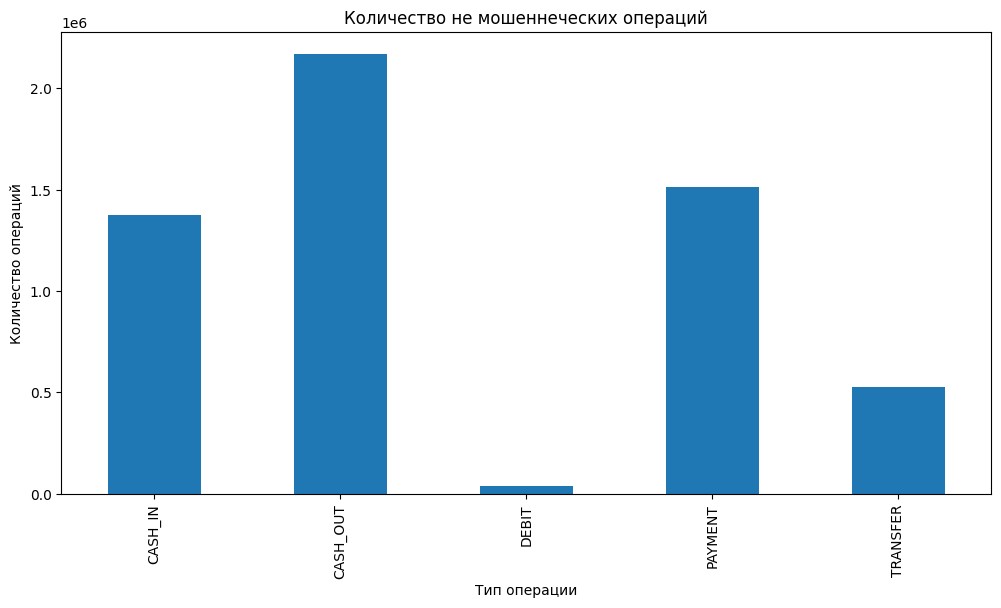

In [27]:
# изменим размер графика, уберем легенду и добавим подписи
ax = FRAUD_DF.plot.bar(figsize = (12,6), legend = None)
ax.set(title = 'Количество не мошеннеческих операций', xlabel = 'Тип операции', ylabel = 'Количество операций')


Аналогично для мошеннических операций

[Text(0.5, 1.0, 'Количество мошеннеческих операций'),
 Text(0.5, 0, 'Тип операции'),
 Text(0, 0.5, 'Количество операций')]

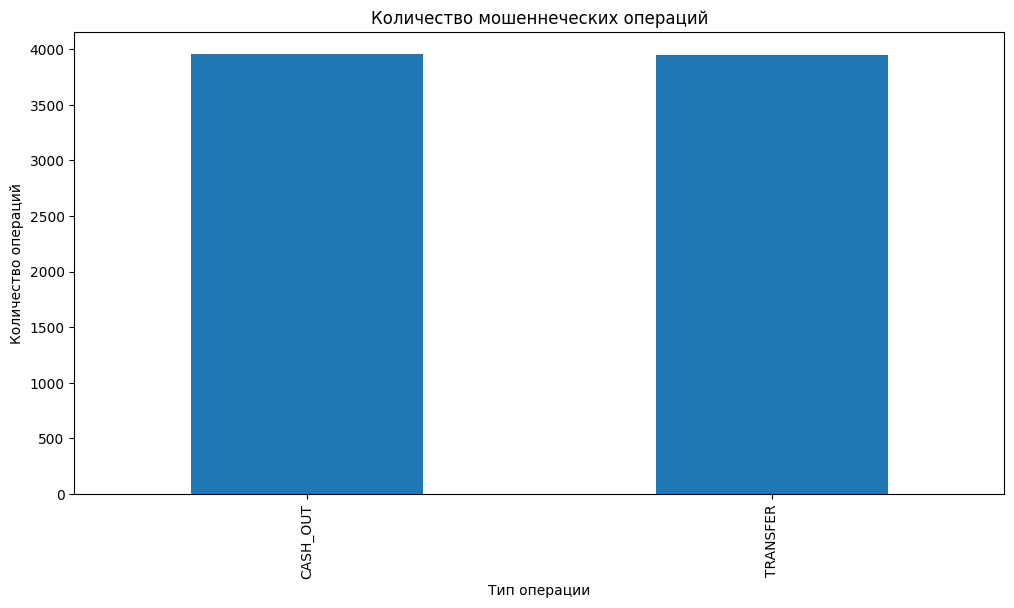

In [28]:
FRAUD_DF = df \
    .select(df.type, df.amount) \
    .filter(df['IsFraud'] == 1) \
    .distinct() \
    .groupBy(df.type) \
    .agg(count('amount').alias('cnt')).toPandas()

FRAUD_DF = FRAUD_DF.set_index('type').sort_index()
ax = FRAUD_DF.plot.bar(figsize = (12,6), legend = None)
ax.set(title = 'Количество мошеннеческих операций', xlabel = 'Тип операции', ylabel = 'Количество операций')
